In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sys
import math
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV,ElasticNetCV
from pyentrp import entropy as pyent
import EntropyHub as EH
import neurokit2 as nk
import random
import sampen
import requests
import io
from pprint import pprint
import os
from sklearn import preprocessing
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client.client.flux_table import FluxTable
from datetime import datetime, timedelta
from typing import List
import itertools
from datetime import datetime
import itertools
from sklearn.tree import DecisionTreeRegressor

In [2]:
c_01 = pd.read_csv("hpq_20221116151815.log", names=["date", "size"])
c_01


,date,size
0,2022-11-16T15:18:10+00:00,14
1,2022-11-16T15:18:11+00:00,14
2,2022-11-16T15:18:12+00:00,14
3,2022-11-16T15:18:13+00:00,14
4,2022-11-16T15:18:14+00:00,14
...,...,...
1021,2022-11-16T15:37:36+00:00,15
1022,2022-11-16T15:37:37+00:00,15
1023,2022-11-16T15:37:38+00:00,15
1024,2022-11-16T15:37:39+00:00,15


In [3]:
def parse(path: str) -> pd.DataFrame:
    # CSVから読み取る
    try:
        df = pd.read_csv(path,  delimiter='\t', header=None, names=[ 'c{0:02d}'.format(i) for i in range(10) ])
    except Exception as e:
        raise(e)
    df_target = df.to_numpy()

    # いい感じに整形
    requests = pd.DataFrame([{"date": datetime.fromtimestamp(float(d[4])/1000), "status": d[6], "count": 1} for d in df_target if (d[0] == "REQUEST" and not math.isnan(float(d[4])) )])
    if len(requests) == 0:
        return pd.DataFrame([])

    # 1秒ごとにサマる
    grouped1 = requests.groupby([pd.Grouper(key=("status")),pd.Grouper(key=("date"), freq="S")]).sum().reset_index()

    # 全部同じ数は困るので乱数を入れておく
    for x in range(len(grouped1)):
        grouped1.iat[x, 2] += np.random.rand() * sys.float_info.epsilon

    return grouped1

In [4]:
df_01 = parse("./simulation_ba2.log")

/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_65013/600845077.py:4: DtypeWarning: Columns (2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,  delimiter='\t', header=None, names=[ 'c{0:02d}'.format(i) for i in range(10) ])


In [5]:
df = pd.read_csv("./simulation_ba2.log",  delimiter='\t', header=None, names=[ 'c{0:02d}'.format(i) for i in range(10) ])

/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_65013/3221606191.py:1: DtypeWarning: Columns (2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./simulation_ba2.log",  delimiter='\t', header=None, names=[ 'c{0:02d}'.format(i) for i in range(10) ])


In [6]:
df_target = df.to_numpy()
requests = pd.DataFrame([{"start": datetime.fromtimestamp(float(d[4])/1000), "end": datetime.fromtimestamp(float(d[5])/1000), "status": d[6], "count": 1} for d in df_target if (d[0] == "REQUEST" and not math.isnan(float(d[4])) and not math.isnan(float(d[5])) )])

In [7]:
requests["duration"] = ((requests["end"] - requests["start"]) / np.timedelta64(1,'ms')).astype(int)
requests

,start,end,status,count,duration
0,2022-11-17 00:18:09.605,2022-11-17 00:18:09.678,OK,1,73
1,2022-11-17 00:18:09.602,2022-11-17 00:18:09.628,OK,1,26
2,2022-11-17 00:18:09.602,2022-11-17 00:18:09.742,OK,1,140
3,2022-11-17 00:18:09.625,2022-11-17 00:18:09.752,OK,1,127
4,2022-11-17 00:18:09.606,2022-11-17 00:18:09.757,OK,1,151
...,...,...,...,...,...
644607,2022-11-17 00:37:39.544,2022-11-17 00:37:39.558,OK,1,14
644608,2022-11-17 00:37:39.544,2022-11-17 00:37:39.559,OK,1,15
644609,2022-11-17 00:37:39.552,2022-11-17 00:37:39.565,OK,1,13
644610,2022-11-17 00:37:39.552,2022-11-17 00:37:39.566,OK,1,14


In [8]:
grouped1 = requests.groupby([pd.Grouper(key=("end"), freq="S"), pd.Grouper(key=("duration"))]).mean().reset_index()

/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_65013/1014284209.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped1 = requests.groupby([pd.Grouper(key=("end"), freq="S"), pd.Grouper(key=("duration"))]).mean().reset_index()


In [9]:
grouped1

,end,duration,count
0,2022-11-17 00:18:09,26,1.0
1,2022-11-17 00:18:09,49,1.0
2,2022-11-17 00:18:09,60,1.0
3,2022-11-17 00:18:09,73,1.0
4,2022-11-17 00:18:09,74,1.0
...,...,...,...
76448,2022-11-17 00:37:39,52,1.0
76449,2022-11-17 00:37:39,53,1.0
76450,2022-11-17 00:37:39,57,1.0
76451,2022-11-17 00:37:39,60,1.0


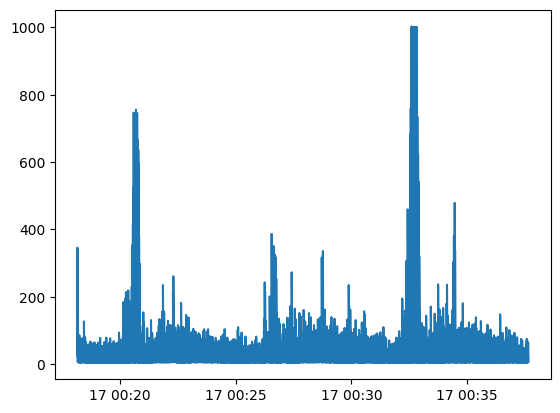

In [10]:
plt.plot(grouped1['end'], grouped1['duration'])

In [11]:
def parse(path: str) -> pd.DataFrame:
    # CSVから読み取る
    try:
        df = pd.read_csv(path,  delimiter='\t', header=None, names=[ 'c{0:02d}'.format(i) for i in range(10) ])
    except Exception as e:
        raise(e)
    df_target = df.to_numpy()

    # いい感じに整形
    requests = pd.DataFrame([{"date": datetime.fromtimestamp(float(d[4])/1000), "count": 1} for d in df_target if (d[0] == "REQUEST" and not math.isnan(float(d[4])) )])
    if len(requests) == 0:
        return pd.DataFrame([])

    # 1秒ごとにサマる
    grouped1 = requests.groupby([pd.Grouper(key=("date"), freq="S")]).sum().reset_index()

    # 全部同じ数は困るので乱数を入れておく
    for x in range(len(grouped1)):
        grouped1.iat[x, 1] += np.random.rand() * sys.float_info.epsilon

    return grouped1

In [12]:
df_01 = parse("./simulation_ba2.log")

/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_65013/3059051602.py:4: DtypeWarning: Columns (2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,  delimiter='\t', header=None, names=[ 'c{0:02d}'.format(i) for i in range(10) ])


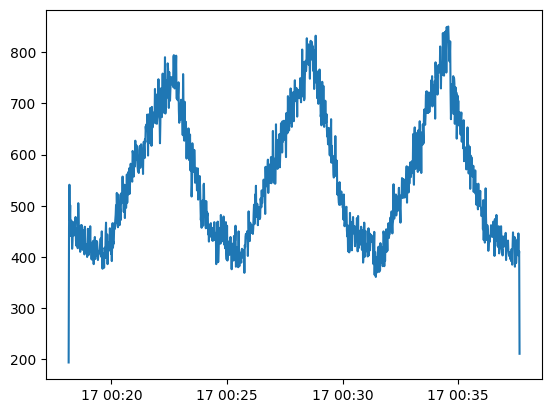

In [13]:
df_01_date = df_01["date"]
df_01_count = df_01["count"]
plt.plot(df_01_date, df_01_count)

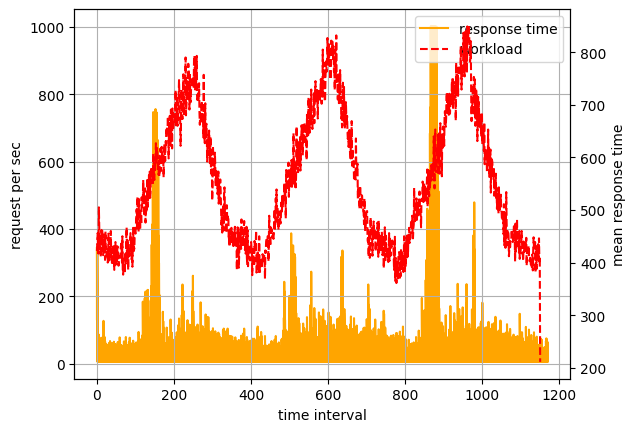

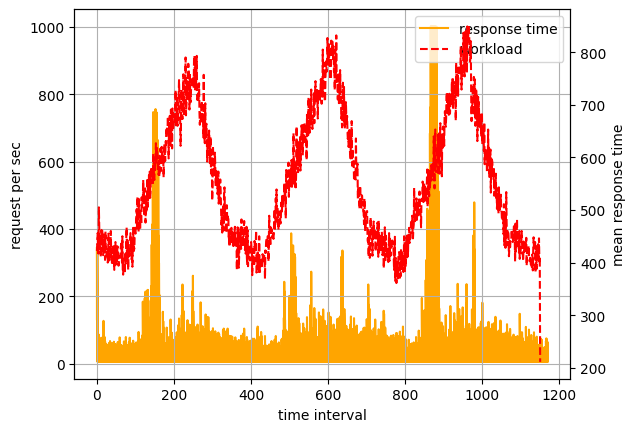

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
df_01_date = df_01["date"][20:]
df_01_count = df_01["count"][20:]
# ln1=ax1.plot(df_01_date, df_01_count, 'C0', zorder=0.1, label='workload')
df_02_date = grouped1['end'][20:]
ln1=ax1.plot([(d - df_02_date[20]).seconds for d in df_02_date], grouped1['duration'][20:], color="orange",  zorder=0.1, label='response time')
ax2 = ax1.twinx()

# ln2=ax2.plot(grouped1['end'][20:],grouped1['duration'][20:],'C1', zorder=0.02, label='response time')
ln2=ax2.plot([(d - df_01_date[20]).seconds for d in df_01_date], df_01_count, color="red",  zorder=0.02, linestyle = "dashed", label='workload')
ax1.set_xlabel(xlabel="time interval")
ax1.set_ylabel(ylabel="request per sec")
ax2.set_ylabel(ylabel="mean response time")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper right')


ax1.grid(True)
plt.savefig("wiki15_response_time_ba2_01.png")